In [1]:
import pandas as pd
import numpy as np
from numpy import var
from numpy import mean
from math import sqrt
from scipy.stats import mannwhitneyu,ttest_ind
from glob import glob
from ast import literal_eval
from collections import Counter
import matplotlib.pyplot as plt
import pingouin as pg
import os

/opt/anaconda3/lib/python3.8/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.3.12, the latest is 0.4.0.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


In [2]:
FOUNDATIONS = ['care', 'fairness', 'liberty', 'loyalty', 'authority', 'sanctity']
FOUNDATIONS_ABBR = ['Care', 'Fair', 'Lbrt', 'Loyal', 'Auth', 'Sanc']
FOUNDATIONS_COLORS = ['#9B5277', '#634FA2', '#5AA2A6', '#78A65A', '#DA954B', '#BB271A']
FOUNDATIONS_COLORS_DARK = ['#4F2A3C', '#352A57', '#305759', '#415930', '#8C6030', '#6E170F']

## Moral Evaluation

#### Secondary moral eval

In [3]:
secondary_moral_eval_df = pd.read_csv('hit/Task_SecondaryMoralEvaluation/secondary_moral_eval_aug21.csv')
secondary_moral_eval_df = secondary_moral_eval_df.sort_values(by=['rot_id', 'HITId'])
secondary_moral_eval_df['annotation_id'] = list(range(len(secondary_moral_eval_df)))
secondary_moral_eval_df['judge'] = np.tile([1,2,3], int(len(secondary_moral_eval_df)/3)) #np.concatenate(judges) #

In [4]:
len(secondary_moral_eval_df)/3

3587.0

In [5]:
import simpledorff
CONSTRUCTS = ['rot_consensus', 'violation_severity', 'care', 'fairness','liberty','loyalty', 'authority', 'sanctity']
CONSTRUCT_NAMES = ['Global Consensus', 'Violation Severity', 'Care', 'Fairness', 'Liberty', 'Loyalty', 'Authority', 'Sanctity']
for construct, construct_name in zip(CONSTRUCTS, CONSTRUCT_NAMES):
    alpha = simpledorff.calculate_krippendorffs_alpha_for_df(secondary_moral_eval_df,
                                                     experiment_col='rot_id',
                                                     annotator_col='WorkerId',
                                                     class_col=construct)
    icc = pg.intraclass_corr(data=secondary_moral_eval_df, targets='rot', raters='judge',
                         ratings=construct, nan_policy='omit').round(3).set_index('Type').loc['ICC1k']['ICC']
    print(f"{construct_name} & {alpha:.2f} & {icc:.2f}\\\\")

Global Consensus & 0.10 & 0.49\\
Violation Severity & 0.12 & 0.62\\
Care & 0.34 & 0.61\\
Fairness & 0.28 & 0.53\\
Liberty & 0.29 & 0.55\\
Loyalty & 0.46 & 0.72\\
Authority & 0.27 & 0.53\\
Sanctity & 0.20 & 0.42\\


#### Primary moral eval

In [6]:
moral_eval_df = pd.read_csv('data/mic/mic_aug21.csv')
for j, which in enumerate(FOUNDATIONS):
    moral_eval_df[which] = [ literal_eval(mv)[j] for mv in moral_eval_df['moral-vector'].values ]

In [7]:
important_qas = set(moral_eval_df[(moral_eval_df['violation-severity']>2) & (moral_eval_df['A_agrees']!=1)]['QA'].values)
all_qas = set(moral_eval_df['QA'].values)
print(f"{len(important_qas)/len(all_qas)*100:.1f}% of QA pairs are considered a big deal, morally speaking")

90.3% of QA pairs are considered a big deal, morally speaking


In [8]:
len(moral_eval_df[(moral_eval_df[['care', 'fairness','liberty','loyalty', 'authority', 'sanctity']].sum(axis=1)==1) & (moral_eval_df['liberty']==1.0)])

2632

In [9]:
2632 / len(moral_eval_df)

0.05912348091740234

#### Dataset Statistics

In [10]:
print(f"There are {len(set(moral_eval_df['QA'])):,} unique QA pairs")
print(f"There are {len(set(moral_eval_df['rot'])):,} unique RoTs")
print(f"There are {len(moral_eval_df):,} structured annotations")
print(f"There are {len(set(moral_eval_df['WorkerId'].values))} unique workers")

There are 14,833 unique QA pairs
There are 39,858 unique RoTs
There are 44,517 structured annotations
There are 133 unique workers


#### Worker Demographic Visualizations

In [11]:
import pandas as pd
worker_leanings = pd.read_csv('data/worker_leanings.tsv', sep='\t')

In [12]:
active_annotators = set(moral_eval_df['WorkerId'].values)
worker_leanings = worker_leanings[[worker_id in active_annotators for worker_id in worker_leanings['WorkerId'].values]]

In [13]:
worker_leanings

,WorkerId,Care,Fairness,Loyalty,Authority,Sanctity,Math,Political
1,A002160837SWJFPIAI7L7,2.0,5.0,1.5,2.0,3.0,0,liberal
8,A10HW8JXM17XLD,4.0,5.0,3.0,2.5,1.5,0,moderate liberal
34,A13XNZBCRSEGGY,5.0,5.0,4.0,3.0,4.0,0,moderate conservative
35,A143XRCI1YXAFE,3.5,4.5,2.0,2.0,2.0,0,liberal
44,A14WLAP6TCEKO0,3.0,4.5,1.0,0.5,0.5,0,moderate liberal
...,...,...,...,...,...,...,...,...
1384,AXGYIT1GX3YD5,4.0,3.0,0.5,0.5,1.5,0,liberal
1386,AXKZUB95CRN72,3.0,4.0,2.0,2.0,2.0,0,moderate liberal
1390,AY7WPVKHVNBLG,4.0,3.5,1.5,3.0,2.5,0,moderate conservative
1401,AZ1KTVBLOCNMM,2.0,1.5,1.0,0.0,3.0,0,moderate liberal


In [14]:
combined = pd.merge(left=moral_eval_df, right=worker_leanings, on='WorkerId')
combined.describe()
for pol in set(combined['Political']):
    c = Counter([ x for s in combined[combined['Political']==pol]['moral'].values if type(s)==str for x in s.split('|')])
    print(pol)
    print({key:c[key]/sum(c.values()) for key in c})

libertarian
{'liberty': 0.08992562542258282, 'authority': 0.044286680189317106, 'sanctity': 0.053076402974983096, 'loyalty': 0.038539553752535496, 'care': 0.2782285327924273, 'fairness': 0.49594320486815413}
liberal
{'care': 0.3903886360841225, 'authority': 0.16203419013651457, 'loyalty': 0.14294059771245848, 'fairness': 0.12061862009592916, 'liberty': 0.1031238470052884, 'sanctity': 0.08089410896568688}
moderate conservative
{'care': 0.43860608131192347, 'loyalty': 0.1883840109326956, 'fairness': 0.10317731465664502, 'sanctity': 0.06299965835326272, 'authority': 0.11615989067304407, 'liberty': 0.09067304407242911}
conservative
{'loyalty': 0.19546520719311963, 'sanctity': 0.06724003127443315, 'care': 0.3776387802971071, 'liberty': 0.12118842845973417, 'authority': 0.09773260359655982, 'fairness': 0.14073494917904614}
moderate liberal
{'sanctity': 0.10087034144164249, 'care': 0.28245183366808, 'authority': 0.1628356765602916, 'loyalty': 0.15822361080116046, 'fairness': 0.148850702968087

In [15]:
Counter(worker_leanings['Political'])

Counter({'liberal': 39,
         'moderate liberal': 49,
         'moderate conservative': 24,
         'libertarian': 9,
         'conservative': 12})

In [16]:
worker_leanings.groupby('Political').mean()

,Care,Fairness,Loyalty,Authority,Sanctity,Math
Political,,,,,,
conservative,3.541667,3.875000,2.625000,2.458333,3.500000,0.000000
liberal,4.051282,4.294872,1.769231,1.615385,2.371795,0.179487
libertarian,3.777778,3.944444,2.166667,1.444444,2.666667,0.000000
moderate conservative,4.062500,4.229167,2.062500,2.020833,3.166667,0.000000
moderate liberal,3.938776,4.183673,2.326531,2.010204,2.448980,0.061224


In [17]:
def normalize_dict(d):
    return {key:d[key]/sum(d.values()) for key in d}

In [18]:
worker_moral_means = combined.groupby('WorkerId').mean()[['care', 'fairness', 'liberty', 'loyalty', 'authority', 'sanctity']]
worker_moral_means['n'] = combined.groupby('WorkerId').count()['Political']
worker_moral_means['Political'] = worker_leanings.set_index('WorkerId')['Political']

In [19]:
from collections import OrderedDict
political_colors = OrderedDict({
    'libertarian': '#FFDF00',
    'liberal': '#0000FF',
    'moderate liberal': '#5050FF',
    'conservative': '#FF0000',
    'moderate conservative': '#FF5050'
})

In [20]:
import matplotlib.pyplot as plt
def make_pie(title, proportions, save_fn=None):
    _, _, autotexts = plt.pie( [proportions[key] for key in political_colors.keys()], 
         labels = ['libertarian', 'liberal', 
                   'moderate liberal', 'conservative', 
                   'moderate\nconservative'], #political_colors.keys(),
         colors = [political_colors[key] for key in political_colors.keys()],
         labeldistance=None,
         autopct='%1.0f%%',
         #pctdistance=1.1
         #explode=[0.05 if key=='liberal' else 0.0 for key in political_colors.keys()]
       )
    for j, autotext in enumerate(autotexts):
        if j:   
            autotext.set_color('white')
            autotext.set_fontsize(12)

    plt.legend(loc='lower left', 
               ncol=int(len(proportions)/2),
               bbox_to_anchor=(-0.15, -0.23),
               fontsize=12
              )
    plt.title(title, fontsize=14)
    if save_fn:
        plt.savefig(save_fn, dpi=600, bbox_inches='tight')

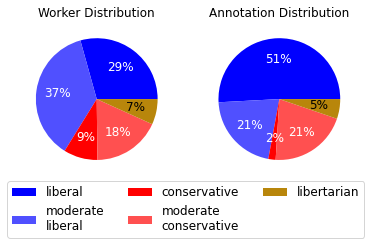

In [21]:
political_colors = OrderedDict({
    'liberal': '#0000FF',
    'moderate liberal': '#5050FF',
    'conservative': '#FF0000',
    'moderate conservative': '#FF5050',
    'libertarian': 'darkgoldenrod'#'#FFDF00'
})

fig, (ax1, ax2) = plt.subplots(1, 2)


proportions = proportions = normalize_dict(Counter(worker_leanings['Political']))
_, _, autotexts = ax1.pie( [proportions[key] for key in political_colors.keys()], 
     labels = ['liberal', 
               'moderate\nliberal', 'conservative', 
               'moderate\nconservative','libertarian'], #political_colors.keys(),
     colors = [political_colors[key] for key in political_colors.keys()],
     labeldistance=None,
     autopct='%1.0f%%',
     pctdistance=0.65
     #explode=[0.05 if key=='liberal' else 0.0 for key in political_colors.keys()]
   )
for j, autotext in enumerate(autotexts):
    if j<len(autotexts)-1:   
        autotext.set_color('white')
    autotext.set_fontsize(12)
ax1.set_title('Worker Distribution')
        
proportions = normalize_dict(Counter(combined['Political']))
_, _, autotexts = ax2.pie( [proportions[key] for key in political_colors.keys()], 
     colors = [political_colors[key] for key in political_colors.keys()],
     labeldistance=None,
     autopct='%1.0f%%',
     pctdistance=0.65
     #explode=[0.05 if key=='liberal' else 0.0 for key in political_colors.keys()]
   )
for j, autotext in enumerate(autotexts):
    if j<len(autotexts)-1:   
        autotext.set_color('white')
    autotext.set_fontsize(12)
ax2.set_title('Annotation Distribution')    

fig.legend(loc='lower left', 
           ncol=3,
           bbox_to_anchor=(0.08, 0),
           fontsize=12
          )
fig.savefig('img/political_leanings.png', dpi=600, bbox_inches='tight')

In [22]:
from numpy import var
from numpy import mean
from math import sqrt
from scipy.stats import mannwhitneyu,ttest_ind

def latex_float(num, sigfigs=3):
    f = "{0:.%se}" % sigfigs
    float_str = f.format(num)
    if "e" in float_str:
        base, exponent = float_str.split("e")
        return r"{0} \times 10^{{{1}}}".format(base, int(exponent))
    else:
        return float_str

def cohend(d1, d2):
    # calculate the size of samples
    n1, n2 = len(d1), len(d2)
    # calculate the variance of the samples
    s1, s2 = var(d1, ddof=1), var(d2, ddof=1)
    # calculate the pooled standard deviation
    s = sqrt(((n1 - 1) * s1 + (n2 - 1) * s2) / (n1 + n2 - 2))
    # calculate the means of the samples
    u1, u2 = mean(d1), mean(d2)
    # calculate Cohen's D
    return (u1 - u2) / s

def format_sig(p1, p2, p, d, title='', sigfigs=3, full_p=False, n1=None, n2=None, scientific=False):
    f = "{:.%sf}" % sigfigs
    prob = f.format(p)
    L = f.format(p1)
    R = f.format(p2)
    D = f.format(d)
    
    if scientific:
        L = latex_float(p1, sigfigs)
        R = latex_float(p2, sigfigs)
    
    stars = ""
    if p<0.05:
        stars += '*'
    if p<0.01:
        stars += '*'
    if p<0.001:
        stars += '*'
        
    if full_p:
        stars += " (p=%s)" % p
        
    sizes = ""
    if n1 and n2:
        sizes = " & %s & %s" % (n1, n2)
    
    if title:
        return "%s %s & %s & %s%s & %s \\\\" % (' '.join(title.split('_')).capitalize(), stars, L, R, sizes, D)
    else:
        return "%s & %s & %s%s & %s \\\\" % (stars, L, R, sizes, D)

def test_binom(d1, d2, alpha=0.05, title="", sigfigs=3, full_p=False, include_n=False):
    n1, n2 = len(d1), len(d2)
    p1, p2 = sum(d1)/n1, sum(d2)/n2
    
    p = (n1*p1 + n2*p2) / (n1 + n2)
    Z = (p1-p2) / np.sqrt(p*(1-p)*((1/n1)+(1/n2)))
    p_value = scipy.stats.norm.sf(abs(Z))*2
    
    D = cohend(d2,d1)
    
    if include_n:
        print(format_sig(p1, p2, p_value, D, title, sigfigs, full_p, n1, n2))
    else:
        print(format_sig(p1, p2, p_value, D, title, sigfigs, full_p))
    
def test(d1, d2, alpha=0.05, title="", sigfigs=3, include_n=False, full_p=False, scientific=False):
    stat, p = mannwhitneyu(d1, d2, alternative='two-sided') #ttest_ind(d1, d2, equal_var=False, nan_policy='omit')
    D = cohend(d2,d1)
    
    if include_n:
        print(format_sig(np.nanmean(d1), np.nanmean(d2), p, D, title, sigfigs, full_p=full_p, n1=len(d1), n2=len(d2), scientific=scientific))
    else:
        print(format_sig(np.nanmean(d1), np.nanmean(d2), p, D, title, sigfigs, full_p=full_p, scientific=scientific))

In [23]:
combined.groupby('Political').mean()

,Unnamed: 0,WorkTimeInMinutes,A_agrees,rot-agree,violation-severity,violation-severity-collapsed,rot-agree-collapsed,care,fairness,liberty,loyalty,authority,sanctity,Care,Fairness,Loyalty,Authority,Sanctity,Math
Political,,,,,,,,,,,,,,,,,,,
conservative,917.274623,8.623986,1.421784,3.404403,2.834299,1.375435,1.424102,0.559676,0.208575,0.179606,0.289687,0.144844,0.099652,3.257822,3.390498,2.620510,2.841251,3.053302,0.000000
liberal,1213.604427,3.581165,1.209340,3.690629,2.958512,1.371891,1.729333,0.560995,0.173331,0.148191,0.205408,0.232846,0.116246,4.662594,4.431295,2.441987,2.187227,3.229422,0.014006
libertarian,1442.079760,1.493525,1.083190,3.936964,3.665952,1.911235,1.976844,0.352916,0.629074,0.114065,0.048885,0.056175,0.067324,4.438894,4.903087,2.446827,0.116424,3.390652,0.000000
moderate conservative,1297.255066,5.990454,1.340449,4.236645,3.804854,2.025897,2.275870,0.695525,0.163615,0.143786,0.298732,0.184202,0.099902,4.387203,4.535540,3.817640,3.091017,3.765955,0.000000
moderate liberal,1235.118816,4.405571,1.301691,3.922199,3.031395,1.572939,1.969662,0.401374,0.211522,0.208562,0.224841,0.231395,0.143340,4.002431,4.127061,2.226268,1.815116,2.622569,0.108774


In [24]:
consider = combined
for which in ['Care', 'Fairness', 'Loyalty', 'Authority', 'Sanctity']:
    L = consider[consider['Political']=='liberal'][which].values
    R = consider[consider['Political']=='conservative'][which].values
    test(L,R, title=which,full_p=False, scientific=False, include_n=True)

Care *** & 4.663 & 3.258 & 22633 & 863 & -3.008 \\
Fairness *** & 4.431 & 3.390 & 22633 & 863 & -1.479 \\
Loyalty * & 2.442 & 2.621 & 22633 & 863 & 0.150 \\
Authority *** & 2.187 & 2.841 & 22633 & 863 & 0.488 \\
Sanctity *** & 3.229 & 3.053 & 22633 & 863 & -0.121 \\


In [25]:
def plot_political_radar(df, cateogories, pols, fn='', y_min=0, y_max=0.889, bbox_to_anchor=(-0.6, -0.3)):

    # number of variables
    N = len(categories)

    for pol in pols:

        color = political_colors[pol]
        # We are going to plot the first line of the data frame.
        # But we need to repeat the first value to close the circular graph:
        values=df.loc[pol].values.flatten().tolist()
        values += values[:1]
        values

        # What will be the angle of each axis in the plot? (we divide the plot / number of variable)
        angles = [n / float(N) * 2 * pi for n in range(N)]
        angles += angles[:1]

        # Initialise the spider plot
        ax = plt.subplot(111, polar=True)

        # Plot data
        ax.plot(angles, values, linewidth=1, linestyle='solid', color=color, label=pol)

        # Fill area
        ax.fill(angles, values, color, alpha=0.1)

    # Draw one axe per variable + add labels
    plt.xticks(angles[:-1], categories, size=12)

    # Draw ylabels
    ax.set_rlabel_position(-45)
    plt.ylim(y_min,y_max)

    # legend
    plt.legend(loc='lower left', 
               ncol=3,
               bbox_to_anchor=bbox_to_anchor,
               fontsize=12
              )

    # Show the graph
    if len(fn):
        print('saving to', fn)
        plt.savefig(fn, dpi=600, bbox_inches='tight')
    plt.show()

<ipython-input-25-a91cfd0de4eb>:20: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.subplot(111, polar=True)


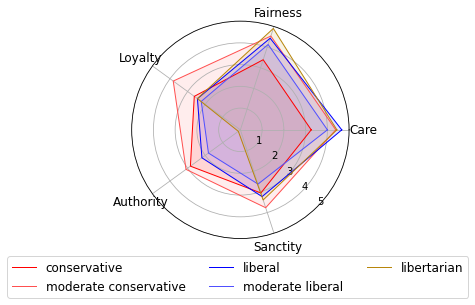

In [26]:
from math import pi

pols = ['conservative',
                'moderate conservative', 
                'liberal', 
                'moderate liberal',
                'libertarian']
categories = ['Care', 'Fairness', 'Loyalty', 'Authority', 'Sanctity']
df = combined.groupby('Political').mean()[categories]
plot_political_radar(df, categories, pols, y_min=0, y_max=5)

<ipython-input-25-a91cfd0de4eb>:20: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.subplot(111, polar=True)


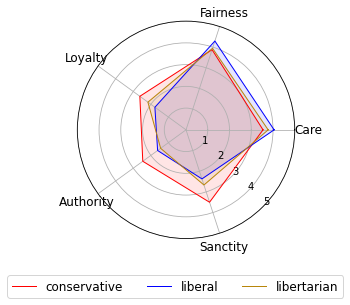

In [27]:
pols = ['conservative',
                #'moderate conservative', 
                'liberal', 
                #'moderate liberal',
                'libertarian']
categories = ['Care', 'Fairness', 'Loyalty', 'Authority', 'Sanctity']
df = worker_leanings.groupby('Political').mean()[categories]
plot_political_radar(df, categories, pols, y_min=0, y_max=5, bbox_to_anchor=(-0.35, -0.3))

In [28]:
categories = ['Care', 'Fairness', 'Loyalty', 'Authority', 'Sanctity']
consider = worker_leanings
for which in ['Care', 'Fairness', 'Loyalty', 'Authority', 'Sanctity']:
    L = consider[consider['Political']=='liberal'][which].values
    R = consider[consider['Political']=='conservative'][which].values
    test(L,R, title=which,full_p=False, scientific=False, include_n=True)

Care  & 4.051 & 3.542 & 39 & 12 & -0.594 \\
Fairness  & 4.295 & 3.875 & 39 & 12 & -0.589 \\
Loyalty * & 1.769 & 2.625 & 39 & 12 & 0.780 \\
Authority * & 1.615 & 2.458 & 39 & 12 & 0.708 \\
Sanctity * & 2.372 & 3.500 & 39 & 12 & 0.840 \\


<ipython-input-25-a91cfd0de4eb>:20: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.subplot(111, polar=True)


saving to img/annotators_mfq.png


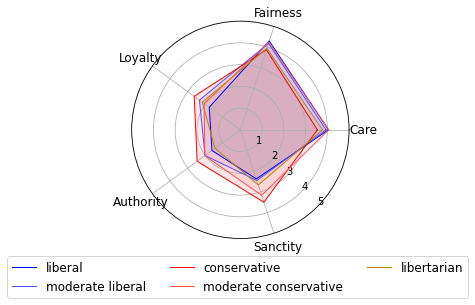

In [29]:
pols = [                'liberal', 
            'moderate liberal',
        'conservative',
                'moderate conservative', 
                'libertarian']
categories = ['Care', 'Fairness', 'Loyalty', 'Authority', 'Sanctity']
df = worker_leanings.groupby('Political').mean()[categories]
plot_political_radar(df, categories, pols, y_min=0, y_max=5, fn='img/annotators_mfq.png')

In [30]:
worker_moral_means = combined.groupby('WorkerId').mean()[['care', 'fairness', 'liberty', 'loyalty', 'authority', 'sanctity']]
worker_moral_means['n'] = combined.groupby('WorkerId').count()['Political']
worker_moral_means['Political'] = worker_leanings.set_index('WorkerId')['Political']
worker_moral_means['num_workers'] = 1

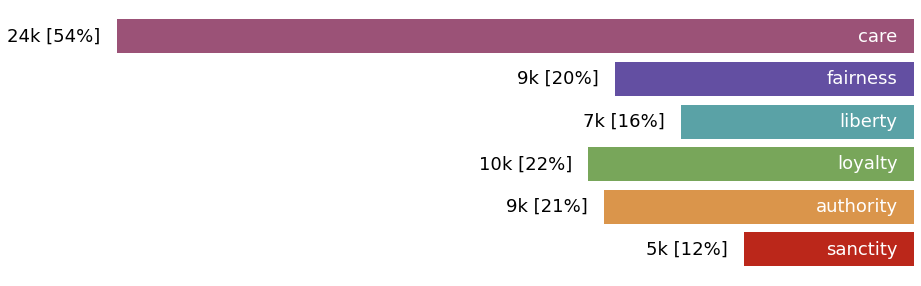

In [31]:
c = Counter([ x for s in moral_eval_df['moral'].values if type(s)==str for x in s.split('|')])
d = {key:c[key]/len(moral_eval_df) for key in c}
counts = [c[f] for f in FOUNDATIONS]
ratios = [d[f] for f in FOUNDATIONS]

plt.rcParams["figure.figsize"] = (15,5)

y_pos = np.arange(len(ratios))
ax = plt.gca()

bar_plot = ax.barh(y_pos, counts, align='center', color=FOUNDATIONS_COLORS)
for idx,rect in enumerate(bar_plot):
    height = rect.get_height()
    width = rect.get_width()
    ax.text(rect.get_x() + 500, rect.get_y() + 0.5*height,
            FOUNDATIONS[idx],
            ha='right', va='center', color='white', fontsize=18, #weight='bold'
           )
    ax.text(rect.get_x() + width + 500, rect.get_y() + 0.5*height,
            f"{counts[idx]/1000:.0f}k [{ratios[idx]*100:.0f}%]",
            ha='right', va='center', color='black', fontsize=18,
           )

plt.axis('off')
ax.invert_yaxis()
ax.invert_xaxis()
if not os.path.exists('img'):
    os.mkdir('img')
plt.savefig('img/moral_foundations.png',dpi=600, bbox_inches='tight')

{'sanctity': 346.6,
 'care': 1263.2,
 'fairness': 583.2,
 'liberty': 339.6,
 'authority': 544.8,
 'loyalty': 476.4}

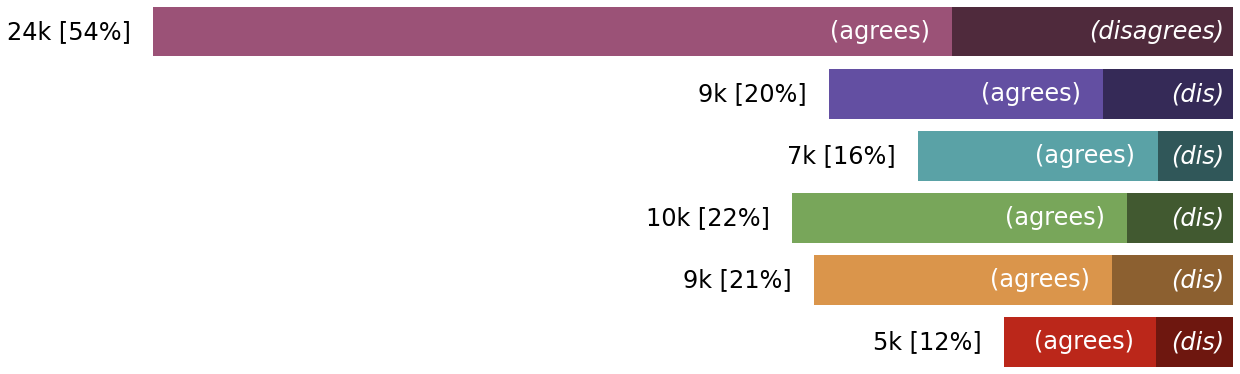

In [32]:
disag = moral_eval_df[moral_eval_df['A_agrees']==0].copy()
c_disag = Counter([ x for s in disag['moral'].values if type(s)==str for x in s.split('|')])
d_disag = {key:c_disag[key]/len(moral_eval_df) for key in c_disag}
counts_disag = [c_disag[f] for f in FOUNDATIONS]
ratios_disag = [d_disag[f] for f in FOUNDATIONS]

c = Counter([ x for s in moral_eval_df['moral'].values if type(s)==str for x in s.split('|')])
d = {key:c[key]/len(moral_eval_df) for key in c}
counts = [c[f] for f in FOUNDATIONS]
ratios = [d[f] for f in FOUNDATIONS]

plt.rcParams["figure.figsize"] = (15,5)

y_pos = np.arange(len(ratios))
ax = plt.gca()

bar_plot = ax.barh(y_pos, counts, align='center', color=FOUNDATIONS_COLORS)
for idx,rect in enumerate(bar_plot):
    height = rect.get_height()
    width = rect.get_width()
    ax.text(rect.get_x() + width + 500, rect.get_y() + 0.5*height,
            f"{counts[idx]/1000:.0f}k [{ratios[idx]*100:.0f}%]",
            ha='right', va='center', color='black', fontsize=24,
           )
bar_plot = ax.barh(y_pos, counts_disag, align='center', color=FOUNDATIONS_COLORS_DARK)
for idx,rect in enumerate(bar_plot):
    height = rect.get_height()
    width = rect.get_width()

    disag = '(disagrees)' if idx in {0} else '(dis)'
    ax.text(rect.get_x()+200, rect.get_y() + 0.5*height,
            disag,
            ha='right', va='center', color='white', fontsize=24, style='italic'#weight='bold'
           )
    ax.text(rect.get_x() + width + 500, rect.get_y() + 0.5*height,
        '(agrees)',
        ha='right', va='center', color='white', fontsize=24, #weight='bold'
       )

plt.axis('off')
ax.invert_yaxis()
ax.invert_xaxis()

## The following is from https://stackoverflow.com/questions/11837979/removing-white-space-around-a-saved-image-in-matplotlib
plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, 
            hspace = 0, wspace = 0)
plt.margins(0,0)
plt.gca().xaxis.set_major_locator(plt.NullLocator())
plt.gca().yaxis.set_major_locator(plt.NullLocator())
plt.savefig('img/moral_foundations_agrees_disagrees.png',dpi=600, bbox_inches='tight')
{key:c_disag[key]/len(disag) for key in c}

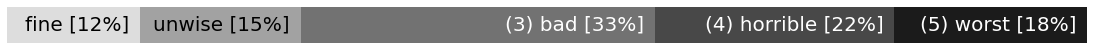

In [33]:
#SEVERITY_COLORS = ['#F6BDC0', '#F07470', '#DC1C13', '#960018', '#000000']
SEVERITY_COLORS = ['#dddddd', '#a2a2a2', '#727272', '#484848', '#1b1b1b']
SEVERITY_NAMES = ['fine', 'unwise', 'bad', 'horrible', 'worst']
c = Counter( moral_eval_df['violation-severity'].values )
d = {key:c[key]/sum(c.values()) for key in c}
ratios = [d[f] for f in sorted(d.keys())]
height = .2

plt.rcParams["figure.figsize"] = (15,0.5)
plt.rcParams['image.cmap'] = 'PuRd'


xpos = 0
y_pos = 0
ax = plt.gca()

for j in range(len(ratios)):
    width = ratios[j]
    plt.bar(xpos, height, width, bottom=0, color=SEVERITY_COLORS[j], align='edge')
    xpos += width
    color = 'white' if j in {2,3,4} else 'black'
    number = f"({j+1}) " if j in {2,3,4} else ""
    text = f"{number}{SEVERITY_NAMES[j]} [{ratios[j]*100:.0f}%]" if j in {2,3} else f"{number}{SEVERITY_NAMES[j]} [{ratios[j]*100:.0f}%]"
    plt.text(xpos-0.01, 0.07, text, color=color,
             fontsize=20,
             ha='right'
            )


plt.axis('off')
plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, 
            hspace = 0, wspace = 0)
plt.margins(0,0)
plt.gca().xaxis.set_major_locator(plt.NullLocator())
plt.gca().yaxis.set_major_locator(plt.NullLocator())
plt.savefig('img/violation_severity.png', dpi=600, bbox_inches='tight')

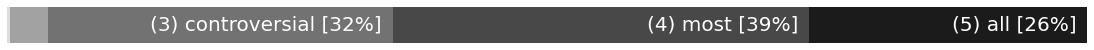

In [34]:
CONSENSUS_COLORS = ['#FFFFFF', '#CEDFF3', '#7DA7D6', '#4B98EB', '#0C59AB', '#00264D']
CONSENSUS_COLORS = ['#dddddd', '#a2a2a2', '#727272', '#484848', '#1b1b1b']
CONSENSUS_NAMES = ['nobody', 'rare', 'controversial', 'most', 'all']
c = Counter( moral_eval_df['rot-agree'].values )
d = {key:c[key]/sum(c.values()) for key in c}
ratios = [d[f] for f in sorted(d.keys())]
height = .2

plt.rcParams["figure.figsize"] = (15,0.5)
plt.rcParams['image.cmap'] = 'PuRd'


xpos = 0
y_pos = 0
ax = plt.gca()

for j in range(len(ratios)):
    width = ratios[j]
    plt.bar(xpos, height, width, bottom=0, color=CONSENSUS_COLORS[j], align='edge')
    xpos += width
    
    color = 'black' if j in {1} else 'white'
    number = f"({j+1}) " if j in {2,3,4} else ""
    text = f"{number}{CONSENSUS_NAMES[j]} [{ratios[j]*100:.0f}%]" if j>1 else ""
    plt.text(xpos-0.01, 0.07, text, color=color,
             fontsize=20,
             ha='right'
            )

plt.axis('off')
plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, 
            hspace = 0, wspace = 0)
plt.margins(0,0)
plt.gca().xaxis.set_major_locator(plt.NullLocator())
plt.gca().yaxis.set_major_locator(plt.NullLocator())
plt.savefig('img/global_consensus.png', dpi=600, bbox_inches='tight')

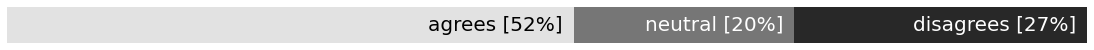

In [35]:
ALIGNMENT_COLORS = ['#E2E2E2', '#767676', '#282828']
ALIGNMENT_NAMES = ['agrees', 'neutral', 'disagrees']
c = Counter( moral_eval_df['A_agrees'].values )
d = {key:c[key]/sum(c.values()) for key in c}
ratios = [d[f] for f in reversed(sorted(d.keys()))]
height = .2

plt.rcParams["figure.figsize"] = (15,0.5)
plt.rcParams['image.cmap'] = 'PuRd'


xpos = 0
y_pos = 0
ax = plt.gca()

for j in range(len(ratios)):
    width = ratios[j]
    plt.bar(xpos, height, width, bottom=0, color=ALIGNMENT_COLORS[j], align='edge')
    xpos += width
    
    color = 'white' if j in {1,2} else 'black'
    text = f"{ALIGNMENT_NAMES[j]} [{ratios[j]*100:.0f}%]"
    plt.text(xpos-0.01, 0.07, text, color=color,
             fontsize=20,
             ha='right'
            )

plt.axis('off')
plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, 
            hspace = 0, wspace = 0)
plt.margins(0,0)
plt.gca().xaxis.set_major_locator(plt.NullLocator())
plt.gca().yaxis.set_major_locator(plt.NullLocator())
plt.savefig('img/answer_alignment.png', dpi=600, bbox_inches='tight')

### Is workers' sense of "global consensus" well-calibrated here?

In [25]:
agree_dfs = {}
for i in range(1,6):
    rots_i = set(moral_eval_df[moral_eval_df['rot-agree']==i]['rot'].values)
    agree_dfs[i] = secondary_moral_eval_df[[rot in rots_i for rot in secondary_moral_eval_df['rot'].values]].copy()

In [37]:
for i in range(1,6):
    consider = agree_dfs[i]
    icc = pg.intraclass_corr(data=consider, targets='rot', raters='judge',
                         ratings='rot_consensus', nan_policy='omit').round(3).set_index('Type').loc['ICC1k']['CI95%']
    alpha = simpledorff.calculate_krippendorffs_alpha_for_df(consider,
                                                 experiment_col='rot_id',
                                                 annotator_col='WorkerId',
                                                 class_col='rot_consensus')
    print(i, icc, alpha)

1 [-0.72  0.88] -0.00691244239631339
2 [0.38 0.66] 0.1722467814098645
3 [0.41 0.5 ] 0.09432070887623911
4 [0.37 0.48] 0.08719333653591133
5 [0.33 0.47] 0.08752976901337406


In [52]:
alphas = []
iccs = []
icc_err = []
for i in range(1,6):
    consider = agree_dfs[i]
    icc = pg.intraclass_corr(data=consider, targets='rot', raters='judge',
                         ratings='violation_severity', nan_policy='omit').round(3).set_index('Type').loc['ICC1k']
    alpha = simpledorff.calculate_krippendorffs_alpha_for_df(consider,
                                                 experiment_col='rot_id',
                                                 annotator_col='WorkerId',
                                                 class_col='violation_severity')
    print(i, icc['CI95%'], alpha)
    alphas.append(alpha)
    iccs.append(icc['ICC'])
    icc_err.append(icc['ICC']-icc['CI95%'][0])
    #icc_uppers.append(icc['CI95%'][1])

1 [-0.64  0.89] 0.1658031088082902
2 [0.46 0.7 ] 0.15844026823412538
3 [0.55 0.62] 0.096192512042228
4 [0.57 0.64] 0.1257554313786814
5 [0.61 0.69] 0.1534301287332357


In [57]:
icc

Description    Average raters absolute
ICC                              0.653
F                                2.883
df1                                779
df2                               1560
pval                               0.0
CI95%                     [0.61, 0.69]
Name: ICC1k, dtype: object

In [49]:
np.linspace(0, 0.17, 5)

array([0.    , 0.0425, 0.085 , 0.1275, 0.17  ])

Text(0.5, 0, 'Global Consensus')

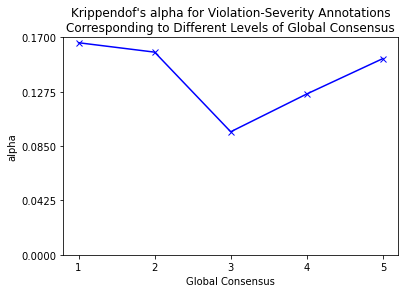

In [65]:
plt.plot(list(range(1,6)), alphas, 'x-b')
plt.xticks(ticks=list(range(1,6)))
plt.yticks(ticks=np.linspace(0, 0.17, 5))
plt.title("Krippendof's alpha for Violation-Severity Annotations\nCorresponding to Different Levels of Global Consensus")
plt.ylabel('alpha')
plt.xlabel('Global Consensus')

In [61]:
# plt.errorbar(list(range(2,6)), iccs[1:], yerr=icc_err[1:], fmt='x-b')
# plt.xticks(ticks=list(range(2,6)))
# #plt.yticks(ticks=np.linspace(0, 0.17, 5))